In [1]:
# Enable auto-reloading so if you change src code, it updates here
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add src to path so we can import our modules
sys.path.append(os.path.abspath(os.path.join('..')))

from src.data_loader import fetch_pair_data
from src.kalman import KalmanFilterReg
from src.strategy import StrategyAnalyzer
from src.backtester import VectorizedBacktester

# Styling for paper-quality plots
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (15, 8)

Fetching Data...
📥 Starting Custom Data Pipeline for PEP & KO...
   -> Requesting PEP via curl_cffi (impersonating Chrome)...
   -> Requesting KO via curl_cffi (impersonating Chrome)...
✅ Data Aligned. 1509 rows ready (Dropped 0 rows).


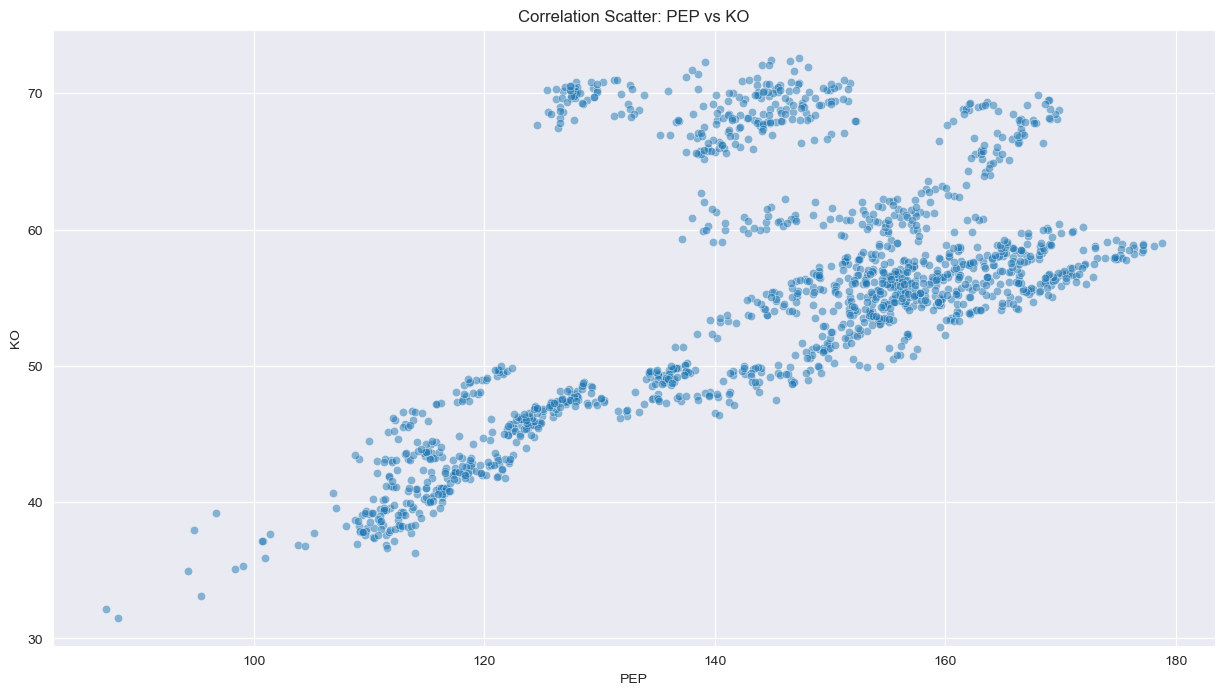

In [2]:
# 1. Define Parameters
TICKER_X = 'PEP'
TICKER_Y = 'KO'
START = '2020-01-01'
END = '2026-01-01'

# 2. Load Data
print("Fetching Data...")
df = fetch_pair_data(TICKER_X, TICKER_Y, START, END)

# 3. Plot Raw Correlation
plt.figure()
sns.scatterplot(x=df[TICKER_X], y=df[TICKER_Y], alpha=0.5)
plt.title(f"Correlation Scatter: {TICKER_X} vs {TICKER_Y}")
plt.xlabel(TICKER_X)
plt.ylabel(TICKER_Y)
plt.show()

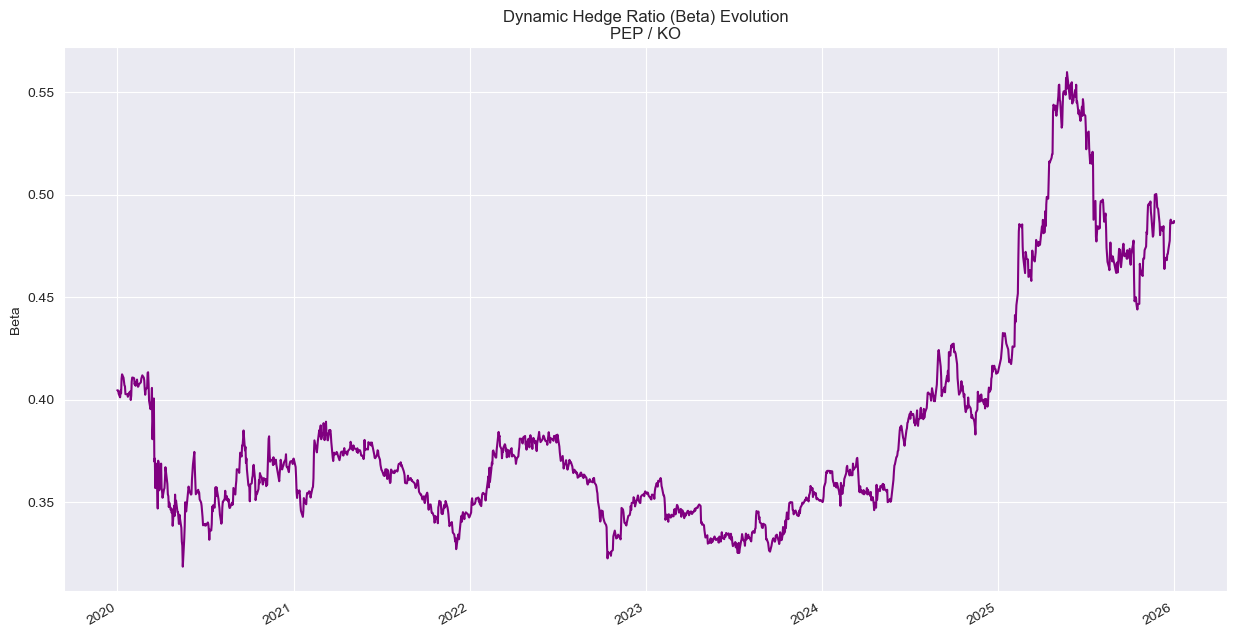

In [3]:
# Initialize and Run Filter
kf = KalmanFilterReg(delta=1e-4, R=1e-3)
kf_results = kf.process_data(df[TICKER_X], df[TICKER_Y])

# Plot the Evolving Beta
plt.figure()
kf_results['beta'].plot(color='purple')
plt.title(f"Dynamic Hedge Ratio (Beta) Evolution\n{TICKER_X} / {TICKER_Y}")
plt.ylabel("Beta")
plt.show()

Total Return: 2.7356
Sharpe Ratio: 0.5105
Max Drawdown: -0.4862


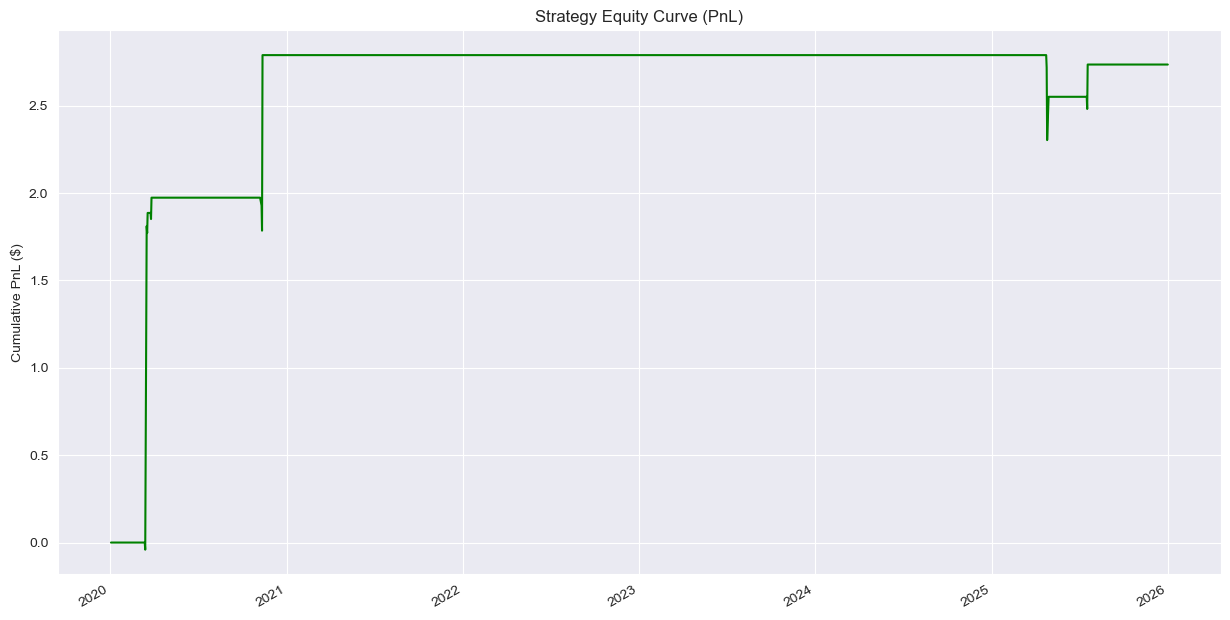

In [4]:
# Generate Signals
strat = StrategyAnalyzer(entry_threshold=2.0, exit_threshold=0.0)
signals = strat.generate_signals(kf_results)

# Prepare Data for Backtest
signals[TICKER_X] = df[TICKER_X]
signals[TICKER_Y] = df[TICKER_Y]

# Run Backtest
bt = VectorizedBacktester(transaction_cost_bps=0.0005) # 5bps cost
metrics = bt.run(signals, TICKER_X, TICKER_Y)

# Print Key Stats for Thesis
print(f"Total Return: {metrics['total_pnl']:.4f}")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
print(f"Max Drawdown: {metrics['max_drawdown']:.4f}")

# Plot Equity Curve
metrics['equity_curve'].plot(title="Strategy Equity Curve (PnL)", color='green')
plt.ylabel("Cumulative PnL ($)")
plt.show()